In [138]:
import os
import datetime
import time
import requests
import json

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_error

In [9]:
!pip install xgboost --q

In [32]:
!pip install catboost --q

In [25]:
!pip install ipywidgets --q

In [27]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [139]:
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor

In [140]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

## First I try **One Hot Encode** the city names

In [141]:
X = pd.read_csv("data/dataset.csv")

In [142]:
X.sample(3)

,city_name,date,pm2_5,pm_2_5-1,pm_2_5-2,pm_2_5-3,pm_2_5-4,pm_2_5-5,mean_7_days,mean_14_days,...,cos_day_of_week,temperature_max,temperature_min,precipitation_sum,rain_sum,snowfall_sum,precipitation_hours,wind_speed_max,wind_gusts_max,wind_direction_dominant
96856,Seattle - KENT - JAMES & CENTRAL,2019-08-14,6.2,4.1,1.9,2.0,3.8,3.0,3.514286,4.907143,...,-0.222521,27.7,15.7,0.0,0.0,0.0,0.0,9.5,27.7,351
60824,Seattle - KENT - JAMES & CENTRAL,2017-04-26,0.8,0.8,1.7,1.4,1.9,2.4,2.214286,2.264286,...,-0.222521,12.6,7.3,5.6,5.6,0.0,17.0,20.6,42.8,205
36460,Phoenix-Mesa,2015-08-26,6.1,6.2,7.0,6.9,6.6,6.4,6.714286,6.878571,...,-0.222521,37.4,26.8,0.1,0.1,0.0,1.0,8.7,28.8,85


In [143]:
# Create OneHotEncoder object
encoder = OneHotEncoder()

# Fit the encoder to the data
encoder.fit(X[['city_name']])

# Transform the data
onehot = encoder.transform(X[['city_name']])

# Convert the output to a dense array and concatenate with the original data
X = pd.concat([X, pd.DataFrame(onehot.todense())], axis=1)

X = X.drop(columns=['date', 'city_name'])
X.columns = X.columns.astype(str)

y = X.pop('pm2_5')

In [144]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

MSE: 30.542052085914236
RMSE: 5.526486414161735
R squared: 0.7367012573980776


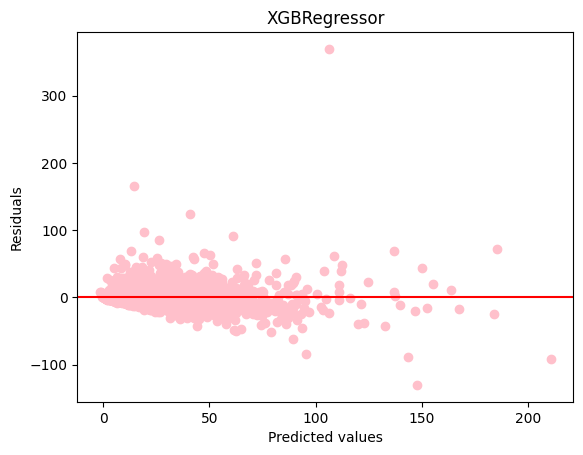

Took 22.01 sec.



In [148]:
start_of_cell = time.time()

xgb_regressor = XGBRegressor()

xgb_regressor.fit(X_train, y_train)

y_pred = xgb_regressor.predict(X_test)

# calculate MSE using sklearn
mse = mean_squared_error(y_test, y_pred)
print("MSE:", mse)

# calculate RMSE using sklearn
rmse = mean_squared_error(y_test, y_pred, squared=False)
print("RMSE:", rmse)

# calculate R squared using sklearn
r2 = r2_score(y_test, y_pred)
print("R squared:", r2)

# plot residuals
residuals = y_test - y_pred
plt.scatter(y_pred, residuals, c="pink")
plt.axhline(y=0, color="r", linestyle='-')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.title("XGBRegressor")
plt.show()

end_of_cell = time.time()
print(f"Took {round(end_of_cell - start_of_cell, 2)} sec.\n")

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

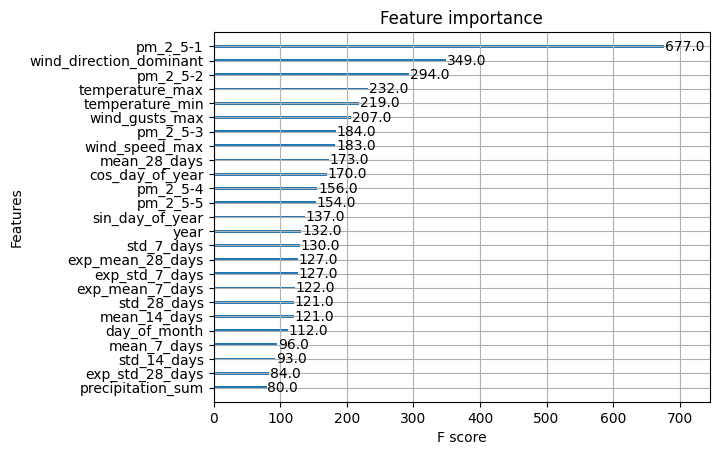

In [149]:
from xgboost import plot_importance

plot_importance(xgb_regressor, max_num_features=25)

In [150]:
import pickle 


# save model to pickle
with open('model.pkl', 'wb') as f:
    pickle.dump(xgb_regressor, f)

In [151]:
# # retrieve model from pickle
# with open('model.pkl', 'rb') as f:
#     model = pickle.load(f)

In [152]:
# with open('onehotencoder.pkl', 'wb') as f:
#     pickle.dump(encoder, f)

## Now I try **Label Encode** the city names

In [153]:
X = pd.read_csv("data/dataset.csv")

In [154]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

# Fit the encoder to the data
le.fit(X[['city_name']])

# Transform the data
encoded = le.transform(X[['city_name']])

/Users/romankah/mambaforge/envs/venv38_new/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/romankah/mambaforge/envs/venv38_new/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


In [155]:
# Convert the output to a dense array and concatenate with the original data
X = pd.concat([X, pd.DataFrame(encoded)], axis=1)

X = X.drop(columns=['date', 'city_name'])
X = X.rename(columns={0: "city_name_encoded"})
X.columns = X.columns.astype(str)

y = X.pop('pm2_5')

In [156]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [157]:
X_train.head(2)

,pm_2_5-1,pm_2_5-2,pm_2_5-3,pm_2_5-4,pm_2_5-5,mean_7_days,mean_14_days,mean_28_days,std_7_days,exp_mean_7_days,...,temperature_max,temperature_min,precipitation_sum,rain_sum,snowfall_sum,precipitation_hours,wind_speed_max,wind_gusts_max,wind_direction_dominant,city_name_encoded
21678,9.0,4.7,5.9,3.8,4.9,6.828571,7.950000,8.396429,2.588252,6.917692,...,27.0,17.1,0.0,0.0,0.0,0.0,15.5,31.3,263,19
149407,4.1,3.6,4.5,3.7,8.4,5.071429,5.807143,22.575000,1.684947,5.261580,...,6.3,1.7,3.4,3.4,0.0,8.0,19.8,44.3,65,31


MSE: 31.75256856259954
RMSE: 5.634941753257041
R squared: 0.7262655648220329


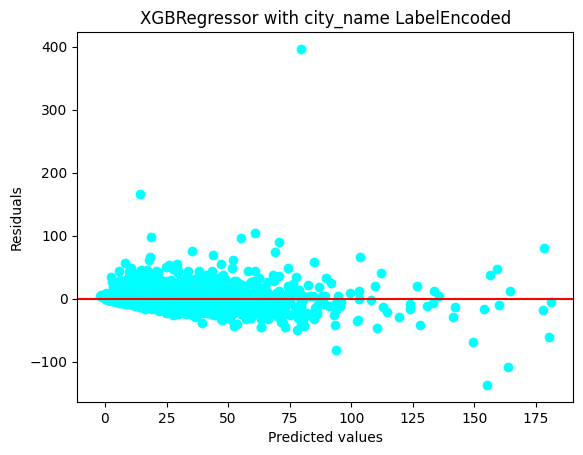

Took 17.6 sec.



In [160]:
start_of_cell = time.time()

xgb_regressor = XGBRegressor()

xgb_regressor.fit(X_train, y_train)

y_pred = xgb_regressor.predict(X_test)

# calculate MSE using sklearn
mse = mean_squared_error(y_test, y_pred)
print("MSE:", mse)

# calculate RMSE using sklearn
rmse = mean_squared_error(y_test, y_pred, squared=False)
print("RMSE:", rmse)

# calculate R squared using sklearn
r2 = r2_score(y_test, y_pred)
print("R squared:", r2)

# plot residuals
residuals = y_test - y_pred
plt.scatter(y_pred, residuals, c="cyan")
plt.axhline(y=0, color="r", linestyle='-')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.title("XGBRegressor with city_name LabelEncoded")
plt.show()

end_of_cell = time.time()
print(f"Took {round(end_of_cell - start_of_cell, 2)} sec.\n")

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

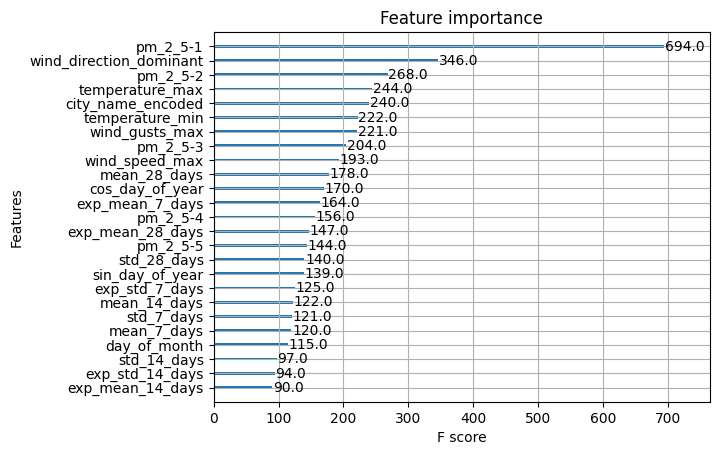

In [159]:
from xgboost import plot_importance

plot_importance(xgb_regressor, max_num_features=25)

In [161]:
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(le, f)

In [162]:
le

LabelEncoder()

In [165]:
le.transform(["London"]), le.transform(["Columbus"])

(array([12]), array([6]))